## Analysis and Exploration of Spatio-temporal graph



**Name: Sai Shruthi Shashidhar**

**Name: Suraj R Gautham**




We are utilizing the England COVID dataset, which is considered a benchmark dataset in PyTorch Geometric Temporal dataset. This dataset contains information on the movement and past cases of COVID-19 in England's NUTS3 regions from March 3 to May 12. The dataset is broken down by day, and the graph is directed and weighted. The graph indicates how many people moved from one region to the other each day, based on Facebook Data For Good disease prevention maps. The node features represent the number of COVID-19 cases in the area over the past eight days. The objective is to anticipate the number of cases in each node after one day. Self-loops on the graph demonstrate the number of individuals who remained in the same location and did not travel elsewhere. Our task is to predict the number of cases in a specific location by analyzing the movement of people from one place to another and taking into account the current number of COVID-19 cases in that area and the node feature, which indicates the number of cases in that location over the last few days.Since COVID-19 has a period of incubation, it is critical to know the number of cases in the preceding few days. We use various techniques with and without hyperparameter tuning to obtain results from the test dataset. We compare these results to determine which approach produces the most optimal outcomes, gaining insight into the effectiveness of each method.

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-geometric-temporal

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**The necessary imports are made. The England Covid Dataset Loader is also imported here.**

In [ ]:
import torch
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric_temporal.nn.recurrent import GCLSTM
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.nn.recurrent import MPNNLSTM
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.nn.recurrent import GConvLSTM

from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader

import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx
import networkx as nx
import json, requests 
import pandas as pd
!pip install community
import community
from networkx.algorithms.community.centrality import girvan_newman
import collections
import itertools


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading COVID-19 cases data for England from an online JSON file. We extract the number of cases for the first day from the data and store it in a list. We then load the EnglandCovidDataset using a custom loader.**

In [ ]:
url = "https://raw.githubusercontent.com/benedekrozemberczki/pytorch_geometric_temporal/master/dataset/england_covid.json"
res = requests.get(url)
text = res.text
data = json.loads(text)
rawCovidCaseForDay0 = []
for i in range(0,len(data["y"])):
  rawCovidCaseForDay0.append(data["y"][i][0])

loader = EnglandCovidDatasetLoader()
dataset = loader.get_dataset()

**A line plot of the Covid cases over time, which shows the overall trend of the data. We observe spikes while the total increases. Through this, we can understand that there is a great increase in the number of cases at regular intervals.**

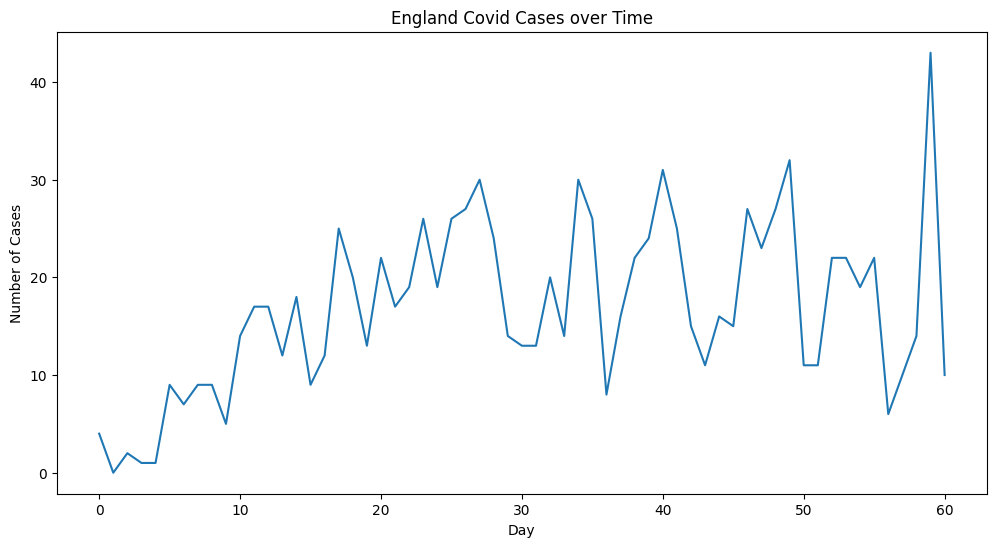

In [ ]:
# convert the raw data to a pandas DataFrame
df = pd.DataFrame(rawCovidCaseForDay0, columns=["CovidCases"])
df.index.name = "Day"
df.reset_index(inplace=True)

# plot a line graph of the Covid cases over time
plt.figure(figsize=(12,6))
sns.lineplot(x="Day", y="CovidCases", data=df)
plt.title("England Covid Cases over Time")
plt.xlabel("Day")
plt.ylabel("Number of Cases")
plt.show()

**Below is a bar plot of the daily Covid cases, which highlights the variation in the data over time.**


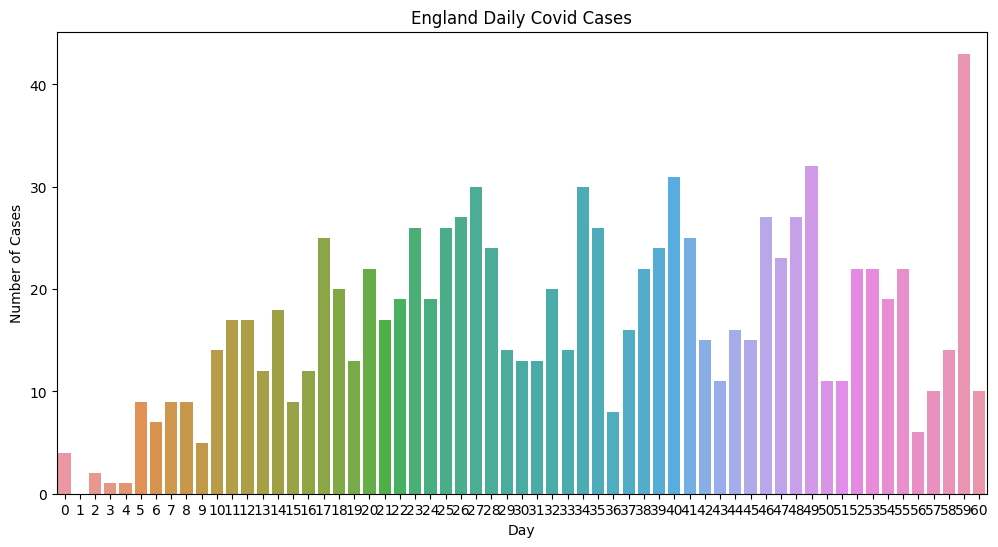

In [ ]:
# plot a bar graph of the daily Covid cases
plt.figure(figsize=(12,6))
sns.barplot(x="Day", y="CovidCases", data=df)
plt.title("England Daily Covid Cases")
plt.xlabel("Day")
plt.ylabel("Number of Cases")
plt.show()

**The following heatmap of the correlation between Covid cases and previous days' cases shows how the current day's cases are related to the cases from the previous few days.**

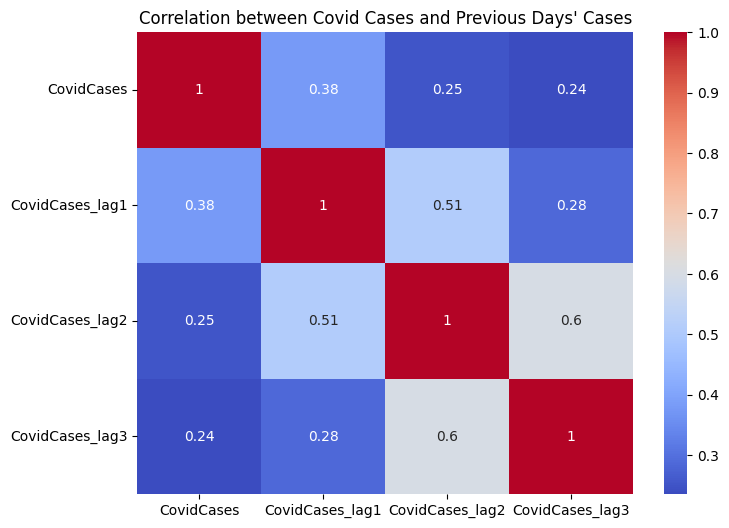

In [ ]:
# create a heatmap of the correlation between Covid cases and previous days' cases
df["CovidCases_lag1"] = df["CovidCases"].shift(1)
df["CovidCases_lag2"] = df["CovidCases"].shift(2)
df["CovidCases_lag3"] = df["CovidCases"].shift(3)
df.dropna(inplace=True)
corr = df[["CovidCases", "CovidCases_lag1", "CovidCases_lag2", "CovidCases_lag3"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Correlation between Covid Cases and Previous Days' Cases")
plt.show()

**To display the the number of nodes, the number of features per node, the number of edges, and the edge density of the graph.**

In [ ]:


# Get the number of nodes and features in the dataset
num_nodes = dataset[0].num_nodes
num_features = dataset[0].x.shape[1]

print("Number of nodes:", num_nodes)
print("Number of features per node:", num_features)

# Get the adjacency matrix of the graph
adj_matrix = torch.sparse_coo_tensor(dataset[0].edge_index,
                                      dataset[0].edge_attr,
                                      (num_nodes, num_nodes)).to_dense()

# Count the number of edges and calculate the edge density
num_edges = adj_matrix.sum()
edge_density = num_edges / (num_nodes * (num_nodes - 1))

print("Number of edges:", num_edges)
print("Edge density:", edge_density)




Number of nodes: 129
Number of features per node: 8
Number of edges: tensor(11486832.)
Edge density: tensor(695.6657)


In [ ]:
G = to_networkx(dataset[1])
#Day 1

** Plotting a network graph using the Fruchterman-Reingold layout algorithm**

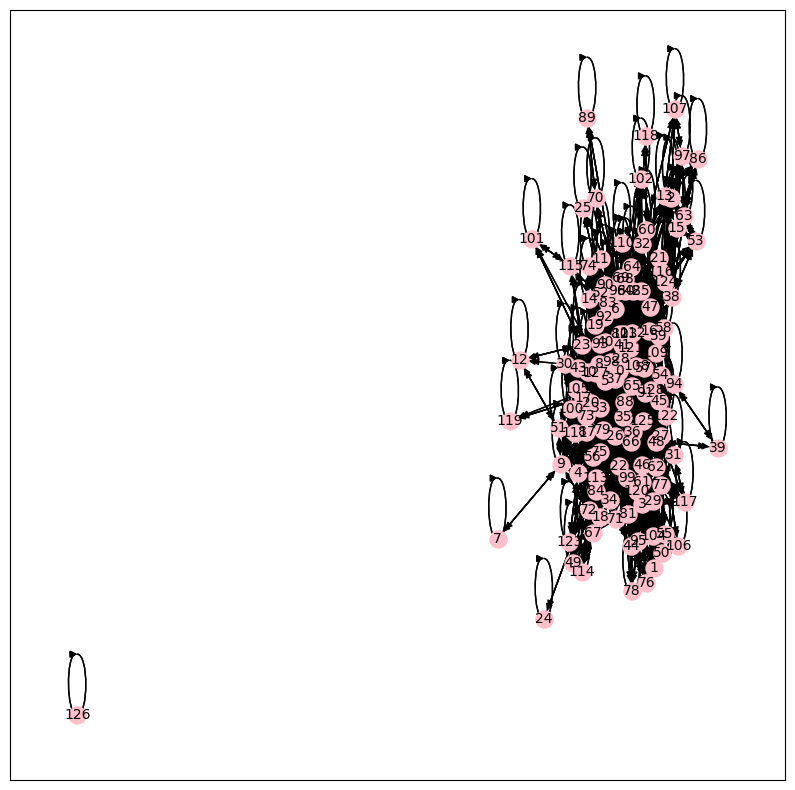

In [ ]:
plt.figure(3, figsize=(10,10))
pos = nx.fruchterman_reingold_layout(G)

nx.draw_networkx(G, pos=pos, node_size = 150, font_size=10, node_color="pink")
nx.draw_networkx_edges(G, pos=pos)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()

**Computing the centrality measures**

In [ ]:

from networkx.algorithms.bipartite.centrality import degree_centrality, closeness_centrality
from operator import itemgetter
degc = nx.degree_centrality(G)
cloc = nx.closeness_centrality(G)
pgrc=nx.pagerank(G)

In [ ]:
sorted_degree = sorted(degc.items(), key=itemgetter(1), reverse=True)[:5]
print("Top 5 nodes with highest degree centrality:", sorted_degree)

Top 5 nodes with highest degree centrality: [(37, 1.0390625), (36, 0.703125), (112, 0.609375), (82, 0.5703125), (0, 0.5390625)]


In [ ]:
centrality_measures = {
    'degree': degc,
    'closeness': cloc,
    'page-rank': pgrc,
}
centrality = pd.DataFrame(centrality_measures)
centrality

,degree,closeness,page-rank
0,0.539062,0.525033,0.017078
1,0.171875,0.397501,0.006808
2,0.156250,0.364184,0.005947
3,0.367188,0.514318,0.013877
4,0.226562,0.439052,0.007337
...,...,...,...
124,0.195312,0.431534,0.007730
125,0.203125,0.425702,0.007085
126,0.015625,0.000000,0.007752
127,0.109375,0.411790,0.004481


In [ ]:
correlations = centrality.corr()
print("Correlation matrix:")
print(correlations)

Correlation matrix:
             degree  closeness  page-rank
degree     1.000000   0.778493   0.981473
closeness  0.778493   1.000000   0.700427
page-rank  0.981473   0.700427   1.000000


In [ ]:
clustering = {
    'Cluster':nx.clustering(G)
}
pd.DataFrame(clustering)

,Cluster
0,0.235659
1,0.784530
2,0.554795
3,0.407216
4,0.494100
...,...
124,0.530864
125,0.575758
126,0.000000
127,0.900000


In [ ]:
avg_clustering = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering)

Average clustering coefficient: 0.5852538864166039


In [ ]:
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.signal import temporal_signal_split

metrics = {}

**General pipeline structure to obtain test results**

In [ ]:
def pipeline(model, optimiser):
    for epoch in tqdm(range(200)):
        cost = 0
        for time, snapshot in enumerate(train_dataset):
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
        cost = cost / (time+1)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    cost = 0
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost = cost.item()
    print("MSE: {:.4f}".format(cost))
    return cost

**DCRNN Model**

In [ ]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_size=32, num_layers=1):
        super(RecurrentGCN, self).__init__()
        self.recurrent1 = DCRNN(node_features, hidden_size, 1)
        self.recurrent2 = DCRNN(hidden_size, hidden_size, num_layers)
        self.linear = torch.nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

rcgn_model = RecurrentGCN(node_features = 8,hidden_size = 16)

optimizer = torch.optim.Adam(rcgn_model.parameters(), lr=0.01)

rcgn_model.train()

metrics['dcrnn'] = pipeline(rcgn_model, optimizer)
print(metrics['dcrnn'])



100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


MSE: 1.0252
1.0251749753952026


**Grid search technique to tune the hyperparameters**

In [ ]:
# Define the hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [16, 32, 64]

# Perform grid search over the hyperparameters
best_loss = float('inf')
best_params = None

for lr, hidden_size in itertools.product(learning_rates, hidden_sizes):
    rcgn_model = RecurrentGCN(node_features=8, hidden_size=hidden_size)
    optimizer = torch.optim.Adam(rcgn_model.parameters(), lr=lr)
    loss = pipeline(rcgn_model, optimizer)
    if loss < best_loss:
        best_loss = loss
        best_params = {'learning_rate': lr, 'hidden_size': hidden_size}

print('Best hyperparameters:', best_params)

100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


MSE: 0.9202


100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


MSE: 0.9814


100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


MSE: 1.0539


100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


MSE: 1.0240


100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


MSE: 1.0383


100%|██████████| 200/200 [00:17<00:00, 11.29it/s]


MSE: 1.0850


100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


MSE: 1.1433


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


MSE: 1.0486


100%|██████████| 200/200 [00:18<00:00, 10.58it/s]


MSE: 1.0464
Best hyperparameters: {'learning_rate': 0.001, 'hidden_size': 16}


In [ ]:
rcgn_model = RecurrentGCN(node_features = 8,hidden_size = best_params['hidden_size'])

optimizer = torch.optim.Adam(rcgn_model.parameters(), lr = best_params['learning_rate'])

rcgn_model.train()

metrics['dcrnn_grid'] = pipeline(rcgn_model, optimizer)
print(metrics['dcrnn_grid'])

100%|██████████| 200/200 [00:17<00:00, 11.23it/s]


MSE: 0.9086
0.9086334705352783


**Random search method for hyperparameter tuning**

In [ ]:
from scipy.stats import randint, uniform

# Define the hyperparameters to tune
param_dist = {'learning_rate': uniform(0.001, 0.1),
              'hidden_size': randint(16, 128)}

# Perform random search over the hyperparameters
n_iter = 10
best_loss = float('inf')
best_params = None

for i in range(n_iter):
    params = {k: v.rvs() for k, v in param_dist.items()}
    rcgn_model = RecurrentGCN(node_features=8, hidden_size=params['hidden_size'])
    optimizer = torch.optim.Adam(rcgn_model.parameters(), lr=params['learning_rate'])
    loss = pipeline(rcgn_model, optimizer)
    if loss < best_loss:
        best_loss = loss
        best_params = params

print('Best hyperparameters:', best_params)


100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


MSE: 1.0553


100%|██████████| 200/200 [00:23<00:00,  8.53it/s]


MSE: 1.0355


100%|██████████| 200/200 [00:21<00:00,  9.13it/s]


MSE: 1.0458


100%|██████████| 200/200 [00:22<00:00,  8.87it/s]


MSE: 1.1289


100%|██████████| 200/200 [00:19<00:00, 10.11it/s]


MSE: 0.9912


100%|██████████| 200/200 [00:23<00:00,  8.54it/s]


MSE: 0.9599


100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


MSE: 1.0443


100%|██████████| 200/200 [00:18<00:00, 10.60it/s]


MSE: 0.9897


100%|██████████| 200/200 [00:28<00:00,  7.06it/s]


MSE: 1.0205


100%|██████████| 200/200 [00:16<00:00, 11.98it/s]


MSE: 1.0352
Best hyperparameters: {'learning_rate': 0.09371694586896812, 'hidden_size': 91}


In [ ]:
rcgn_model = RecurrentGCN(node_features = 8,hidden_size = best_params['hidden_size'])

optimizer = torch.optim.Adam(rcgn_model.parameters(), lr=best_params['learning_rate'])

rcgn_model.train()

metrics['dcrnn_random'] = pipeline(rcgn_model, optimizer)
print(metrics['dcrnn_random'])

100%|██████████| 200/200 [00:24<00:00,  8.01it/s]


MSE: 0.9686
0.9686404466629028


**GCLSTM**

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0
        
gclstm_model = RecurrentGCN(node_features=8)

optimizer = torch.optim.Adam(gclstm_model.parameters(), lr=0.01)

gclstm_model.train()

for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = gclstm_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
gclstm_model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = gclstm_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

metrics['gclstm'] = cost

100%|██████████| 200/200 [00:09<00:00, 21.52it/s]


MSE: 1.0500


In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0
        
gconvlstm_model = RecurrentGCN(node_features=8)

optimizer = torch.optim.Adam(gconvlstm_model.parameters(), lr=0.01)

gconvlstm_model.train()

for epoch in tqdm(range(250)):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = gconvlstm_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
gconvlstm_model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = gconvlstm_model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))
metrics['chebyshev'] = cost

100%|██████████| 250/250 [00:20<00:00, 12.34it/s]


MSE: 1.8555


In [ ]:
metrics
for key in metrics.keys():
    metrics[key] = 1/metrics[key]

**Analysis and Conclusion**

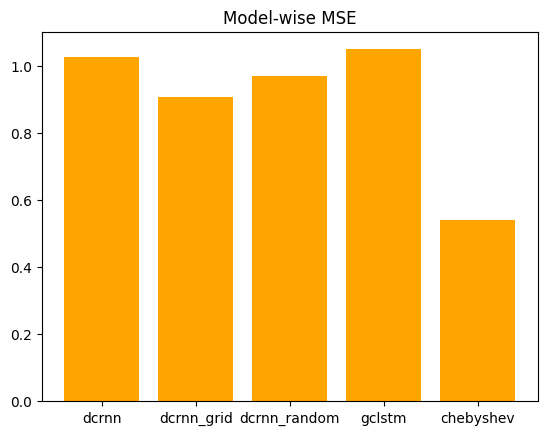

In [ ]:
plt.bar(range(len(metrics)), list(metrics.values()), align='center',color = 'orange')
plt.xticks(range(len(metrics)), list(metrics.keys()))
plt.title("Model-wise MSE")
plt.show()

In [ ]:
metrics

{'dcrnn': 1.0251749753952026,
 'dcrnn_grid': 0.9086334705352784,
 'dcrnn_random': 0.9686404466629028,
 'gclstm': 1.0499744415283203,
 'chebyshev': 0.5389399585506316}

**Conclusions**

During this round of training and testing, it was discovered that the GConV LSTM model utilizing a Chebyshev filter performed the best with the lowest MSE. While the other models were fairly similar in performance, it's worth mentioning that the results varied with each iteration.

To enhance the project, it would be beneficial to incorporate more features and conduct a more thorough exploratory data analysis. The results could be further improved by enhancing the methods used for tuning hyperparameters. Furthermore, combining these models using an ensemble approach could potentially lead to even better outcomes.